In [2]:
import json
import os
import subprocess
from IPython.display import clear_output
import torch.optim as optim

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cuda


# Generate metrics

In [2]:
from functions_utils_pomo import get_metrics     

In [3]:
cur_path = os.getcwd()
metrics = get_metrics(cur_path)
os.chdir('./Reward_weights')
for m in metrics:

    dic_tarif_sent_disp = {'v_required': 0,
                    'v_sent': 0,
                    'v_sent_full':0,
                    'v_degraded':0,
                    'cancelled':0, #cancel departure
                    'function_not_found':0,
                    'v1_not_sent_from_s1':0,
                    'v3_not_sent_from_s3':0,
                    'v_not_found_in_last_station':0,
                    'ff_required':0,
                    'ff_sent':0,
                    'rupture_ff':0,       
                    'z1_VSAV_sent': 0,
                    'z1_FPT_sent': 0,
                    'z1_EPA_sent': 0,
                     'VSAV_needed':0,
                     'FPT_needed':0,
                     'EPA_needed':0,
                     'VSAV_disp':0,
                     'FPT_disp':0,
                     'EPA_disp':0,
                    'skill_lvl':0
                    } 

    dic_tarif_sent_disp[m] = -100

    if m == 'v_degraded':
        
        dic_tarif_sent_disp['v_sent_full'] = 10


    with open(f"rw_"+ m +"_r100_cf3.json", "w") as f:
        json.dump(dic_tarif_sent_disp, f)

os.chdir("../")

In [5]:
os.chdir('./Reward_weights')
metric = "v1_not_sent_from_1st_station"
with open(f"rw_{metric}_r100_cf3.json", "r") as f:
    d = json.load(f)
os.chdir("../")
d

{'v_sent': 0,
 'v_sent_full': 0,
 'v_degraded': 0,
 'cancelled': 0,
 'function_not_found': 0,
 'v1_not_sent_from_1st_station': -100,
 'v_not_found_in_last_station': 0,
 'z1_sent': 0,
 'skill_lvl': 0}

# Agent params POMO

In [6]:
path = "./SVG_model/shared_state_pomo.pt"
data = torch.load(path, map_location=device,weights_only=False)
print("Type :", type(data))
print(data.shape)
print(data)

Type : <class 'numpy.ndarray'>
(82, 40)
[[0.93103448 1.         0.88888889 ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.125      0.125      0.125      ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
for metric in metrics:
    file_path = f"Reward_weights/rw_pomo_agent_{metric}_r100_cf3.json"
    try: os.remove(file_path)
    except FileNotFoundError: print(f"File '{file_path}' not found.")
print()

#-------Start
intervalle = 40
start = 1

while start <= 53080:
    
    end = start + intervalle - 1
    if end > 53080: end = 53080
    cmd = ["python3", "-u", "agent_pomo_run.py", "--start", str(start), "--end", str(end)]

    process = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1
    )

    line_count = 0
    for line in process.stdout:
        line_count += 1
        #if line_count % 100 == 0:
           #clear_output(wait=True)

        print(line.strip())
    
    process.wait()
    
    start += intervalle
    

I copy-pasted the output of previous block in the log.txt file so we can load this ipynb file in github

In [8]:
path = "./SVG_model/shared_state_pomo.pt"
data = torch.load(path, map_location=device,weights_only=False)
print("Type :", type(data))
print(data.shape)
print(data)

Type : <class 'numpy.ndarray'>
(82, 40)
[[1.         1.         0.85185185 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.125      0.         0.5        ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# Reward  obtenu après itération

In [12]:
os.chdir('./Reward_weights')
metric = "v_degraded"
with open(f"rw_pomo_agent_{metric}_r100_cf3.json", "r") as f:
    d = json.load(f)
os.chdir("../")
d

{'v_required': 55,
 'v_sent': 56,
 'v_sent_full': 55,
 'v_degraded': 1,
 'rupture_ff': 6,
 'function_not_found': 5,
 'v1_not_sent_from_s1': 11,
 'v3_not_sent_from_s3': 0,
 'v_not_found_in_last_station': 0,
 'ff_required': 0,
 'ff_sent': 200,
 'z1_VSAV_sent': 0,
 'z1_FPT_sent': 0,
 'z1_EPA_sent': 0,
 'VSAV_needed': 0,
 'FPT_needed': 0,
 'EPA_needed': 0,
 'VSAV_disp': 8,
 'FPT_disp': 0,
 'EPA_disp': 0,
 'skill_lvl': 331.0}

# Reward Mean

In [3]:
os.chdir('./Reward_weights')
metric = "v_degraded"
with open(f"rw_mean_pomo_agent_{metric}_r100_cf3.json", "r") as f:
    d = json.load(f)
os.chdir("../")
d

682.99

# NEW version POMO test

In [ ]:
from agent import POMO_Agent
import torch
import torch.optim as optim

def generate_instances(batch_size, n_nodes, device):
    return torch.rand(batch_size, n_nodes, 2, device=device)

def compute_tour_length(coords, tours):
    B, P, N = tours.size()
    tour_coords = torch.gather(coords.unsqueeze(1).expand(-1, P, -1, -1), 2, tours.unsqueeze(-1).expand(-1, -1, -1, 2))
    rolled = torch.roll(tour_coords, shifts=-1, dims=2)
    lengths = ((tour_coords - rolled) ** 2).sum(dim=-1).sqrt().sum(dim=-1)
    return lengths

N_EPOCHS = 200
BATCH_SIZE = 64
N_NODES = 80
POMO_SIZE = 2

torch.cuda.empty_cache()

hyper_params = {
    "node_feature_size": 2,  # (x,y)
    "hidden_size": 64,      # Taille des embeddings
    "num_layers": 3,         # Nombre de couches dans l'encodeur
    "use_batchnorm": False,
    "device": device,
    "seed": 41
}

model = POMO_Agent(**hyper_params)
network = model.qnetwork_local

for epoch in range(N_EPOCHS):
    coords = generate_instances(BATCH_SIZE, N_NODES, device)  # [B, N, 2]
    B = coords.size(0)
    
    log_probs = []  # Réinitialiser à chaque epoch
    rewards = []    # Réinitialiser à chaque epoch

    for _ in range(POMO_SIZE):
        mask = torch.zeros(B, N_NODES, device=device)  # Masque initial
        tour = []
        log_p = []
        
        for _ in range(N_NODES):
            # Obtient les logits pour toutes les villes (masquées si déjà visitées)
            logits = network(coords, mask)  # [B, N]
            probs = torch.softmax(logits, dim=-1)
            
            # Échantillonne une action
            m = torch.distributions.Categorical(probs)
            action = m.sample()  # [B]
            
            # Met à jour le masque et enregistre l'action
            mask[torch.arange(B), action] = -float('inf')
            tour.append(action)
            log_p.append(m.log_prob(action))
        
        # Calcule la longueur du tour et les log-probs
        tour = torch.stack(tour, dim=1)  # [B, N]
        log_p = torch.stack(log_p, dim=1)  # [B, N]
        
        log_probs.append(log_p.sum(dim=1))  # [B]
        rewards.append(compute_tour_length(coords, tour.unsqueeze(1)).squeeze(1))  # [B]

    # Stack les résultats pour POMO
    log_probs = torch.stack(log_probs, dim=1)  # [B, P]
    rewards = torch.stack(rewards, dim=1)      # [B, P]

    # Calcul du POMO baseline et de la loss
    baseline = rewards.mean(dim=1, keepdim=True)
    advantage = baseline - rewards  # On veut minimiser la longueur
    loss = (advantage.detach() * log_probs).mean()

    # Backpropagation
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()

    if epoch % 50 == 0:
        avg_reward = rewards.min(dim=1)[0].mean().item()  # Meilleur tour par instance
        print(f"Epoch {epoch}, Avg reward: {avg_reward:.4f}")

Epoch 0, Avg reward: 39.7859
Epoch 50, Avg reward: 41.7350
Epoch 100, Avg reward: 52.0276
Epoch 150, Avg reward: 50.0130


# Real POMO

In [2]:
import pandas as pd
import numpy as np
import json
import os
from collections import defaultdict, deque
import pickle
from IPython import get_ipython
from tqdm.auto import tqdm
import gc
import subprocess
from IPython.display import clear_output
import matplotlib.pyplot as plt
import wandb
import pickle

/home/brandon/Projet_TER/TEST_byMe/env_pompier/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
model = "pomo"
years = "1y"
suffix = "cfv1p1"
rwd="rupture_ff"

cmd = [
    "python3", "-u", "agent_run.py",
    "--model_name", f"agent_{model}_{years}_{suffix}_{rwd}",
    "--agent_model", model,
    "--hyper_params", "hyper_params.json",
    "--reward_weights", f"rw_{rwd}.json",
    "--dataset", f"df_pc_fake_{years}.pkl",
    "--start", "1",
    "--end", "53088",
    "--constraint_factor_veh", "1",
    "--constraint_factor_ff", "1",
    "--save_metrics_as", f"metrics_{model}_{years}_{suffix}_{rwd}",
    "--eps_start","1",
    "--train"
    

]
# "--train"
# "--end", "53088",
# "--load"

process = subprocess.Popen(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)

line_count = 0
stdout_lines = deque(maxlen=5000)
for line in process.stdout:
    stdout_lines.append(line)
    line_count += 1
    if line_count % 100 == 0:
        clear_output(wait=True)

    print(line.strip())

max_train_steps 265435
Agent pomo initialized
Train mode
Reward weights {'v_required': 0, 'v_sent': 0, 'v_sent_full': 0, 'v_degraded': 0, 'cancelled': 0, 'function_not_found': 0, 'v1_not_sent_from_s1': 0, 'v3_not_sent_from_s3': 0, 'v_not_found_in_last_station': 0, 'ff_required': 0, 'ff_sent': 0, 'rupture_ff': -100, 'z1_VSAV_sent': 0, 'z1_FPT_sent': 0, 'z1_EPA_sent': 0, 'VSAV_needed': 0, 'FPT_needed': 0, 'EPA_needed': 0, 'VSAV_disp': 0, 'FPT_disp': 0, 'EPA_disp': 0, 'skill_lvl': 0}
constraint factor veh is  1
constraint factor ff is  1 Number of ff: 3343
Z_4 ['CADOURS', 'CARBONNE', 'CAZERES', 'ASPET', 'CINTEGABELLE', 'AURIGNAC', 'ISLE EN DODON', 'LE FOUSSERET', 'MONTESQUIEU VOLVESTRE', 'MONTREJEAU', 'REVEL', 'BAGNERES DE LUCHON', 'RIEUMES', 'RIEUX VOLVESTRE', 'SALIES DU SALAT', 'ST BEAT', 'ST GAUDENS', 'ST MARTORY', 'VILLEFRANCHE DE LAURAGAIS', 'VILLEMUR S/TARN', 'BOULOGNE SUR GESSE']
df start-end 0 106173
eps_start 1.0 eps_update 2308
wandb: Currently logged in as: brandon-afonso3118 (

KeyboardInterrupt: 

In [3]:
with open("Plots/metrics_pomo_1y_cfv1p1_rupture_ff.pkl", "rb") as f:
    met2 = pickle.load(f)
met2

{'v_required': 62856,
 'v_sent': 63454,
 'v_sent_full': 62723,
 'v_degraded': 731,
 'rupture_ff': 5867,
 'function_not_found': 6030,
 'v1_not_sent_from_s1': 11255,
 'v3_not_sent_from_s3': 7,
 'v_not_found_in_last_station': 133,
 'ff_required': 0,
 'ff_sent': 197534,
 'z1_VSAV_sent': 136,
 'z1_FPT_sent': 0,
 'z1_EPA_sent': 0,
 'VSAV_needed': 159,
 'FPT_needed': 0,
 'EPA_needed': 0,
 'VSAV_disp': 5,
 'FPT_disp': 6,
 'EPA_disp': 0,
 'skill_lvl': 285679.0}

In [9]:
# Charger le .pkl
with open("Plots/agent_pomo_1y_cfv1p1_rupture_ff_reward_evo.pkl","rb") as f:
    data = pickle.load(f)  # ex: [[step, reward], [step, reward], ...]

# Convertir en tableau NumPy
data_array = np.array(data)

# Sauvegarder en .npy
np.save("Plots/pomo_reward.npy", data_array)

print("Conversion terminée : pomo_reward.npy créé")

Conversion terminée : pomo_reward.npy créé


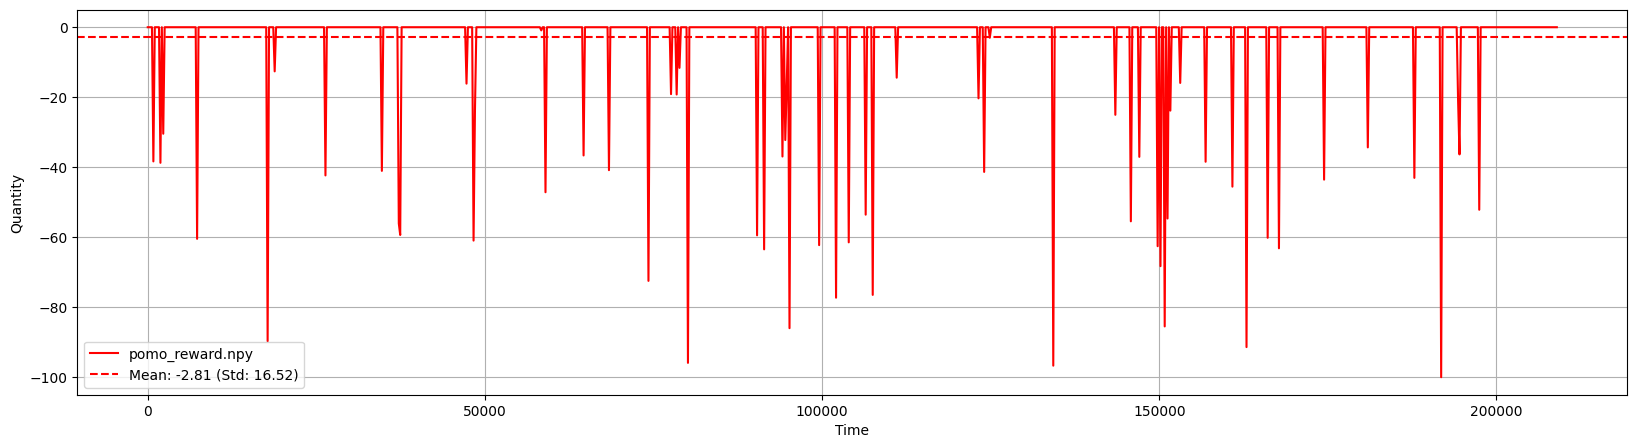

Fin du script. Tout s’est bien déroulé.


In [4]:
%run plot_evo.py pomo_reward.npy --interpolation 1000

In [18]:
os.getcwd()

'/home/brandon/Projet_TER/TEST_byMe'

besoin de modifier l'encodeur et le decodeur poour marquer l'attention ...